# LAB 7: Transfer Learning - Ejemplo

**Ingeniería Electrónica**

**Inteligencia Artificial**

**15/06/2022**

**Transferir el aprendizaje** permite tomar un pequeño conjunto de datos y producir un modelo preciso. Este método utiliza grandes redes que fueron entrenadas durante mucho tiempo en grandes conjuntos de datos, transfiriendo ese conocimiento a nuestra propia red. Para esto utilizaremos la API de [Weights & Biases](https://wandb.ai/site), por lo que primero es necesario registrarse en W&B y crear un proyecto con el nombre "transfer_learn".

Reutilizaremos una red para detección de alimentos (_groceries_), usando el script `groceries.py` que desarga el dataset de [Freiburg](https://github.com/PhilJd/freiburg_groceries_dataset)

In [3]:
!pip install wandb -qqq
import wandb

     |████████████████████████████████| 1.8 MB 35.9 MB/s 
     |████████████████████████████████| 181 kB 61.8 MB/s 
     |████████████████████████████████| 145 kB 53.7 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 


In [4]:
# Iniciar sesión en su cuenta W&B
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
import os
os.environ["WANDB_ENTITY"] = "mlclass"

In [6]:
import keras
import wandb
from wandb.keras import WandbCallback
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.resnet import ResNet50, decode_predictions, preprocess_input
from keras.utils import np_utils
import groceries
import matplotlib.pyplot as plt

In [7]:
(x_train, y_train_raw), (x_test, y_test_raw), class_names = groceries.load_data()

Extracting dataset.
Done.


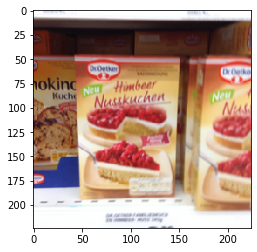

In [12]:
# echar un vistazo a los tipos de imágenes que estamos tratando
plt.imshow(x_train[200].astype(int))

In [13]:
# Imprime las clases objetivo
class_names

['BEANS',
 'CAKE',
 'CANDY',
 'CEREAL',
 'CHIPS',
 'CHOCOLATE',
 'COFFEE',
 'CORN',
 'FISH',
 'FLOUR',
 'HONEY',
 'JAM',
 'JUICE',
 'MILK',
 'NUTS',
 'OIL',
 'PASTA',
 'RICE',
 'SODA',
 'SPICES',
 'SUGAR',
 'TEA',
 'TOMATO_SAUCE',
 'VINEGAR',
 'WATER']

(array([639., 439., 672., 199., 406., 602., 295., 504., 381., 560.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

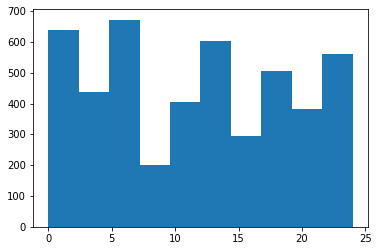

In [14]:
# comprobar qué tan balanceada es la distribución de clases
plt.hist(y_train_raw)

In [15]:
# Codificar las salidas
y_train = keras.utils.np_utils.to_categorical(y_train_raw)
y_test = keras.utils.np_utils.to_categorical(y_test_raw)

In [16]:
# Cargar ResNet50 entrenada en imagenet
resnet_model = ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 1s 0us/step


In [17]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [21]:
from keras.preprocessing import image
import numpy as np
img = image.load_img('ESFERO.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = resnet_model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02783161', 'ballpoint', 0.87671465), ('n04116512', 'rubber_eraser', 0.09535557), ('n03908714', 'pencil_sharpener', 0.009283924)]


In [22]:
# Deberíamos preprocesar las imágenes de la misma manera que se preprocesaron las imágenes resnet
x_train_preprocessed = preprocess_input(x_train)
x_test_preprocessed = preprocess_input(x_test)

In [23]:
# Crear un nuevo modelo que sea ResNet50 menos la última capa
last_layer = resnet_model.get_layer("avg_pool")

resnet_layers = keras.Model(inputs=resnet_model.inputs, outputs=last_layer.output)
resnet_layers.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [24]:
# Podemos unir directamente los modelos

new_model=Sequential()
new_model.add(resnet_layers)
new_model.add(Dense(25, activation="sigmoid"))

new_model.layers[0].trainable=False

new_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 25)                51225     
                                                                 
Total params: 23,638,937
Trainable params: 51,225
Non-trainable params: 23,587,712
_________________________________________________________________


In [26]:
# Podemos permitir que algunas de las capas de resnet cambien mientras entrenamos.

new_model.layers[0].trainable = True

# We let the last 3 blocks train
for layer in new_model.layers[0].layers[:-11]:
    layer.trainable = False
for layer in new_model.layers[0].layers[-11:]:
    layer.trainable = True
    
new_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

#wandb.init(project="transfer_learn")
#wandb.init(project="transfer_learn", settings=wandb.Settings(start_method="thread"))
wandb.init(project="transfer_learn", entity="edissonortiz")
new_model.fit(x_train_preprocessed, y_train, epochs=50, validation_data=(x_test_preprocessed, y_test), callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
147/147 [==============================] - 763s 5s/step - loss: 1.2621 - accuracy: 0.6421 - val_loss: 2.3774 - val_accuracy: 0.5920 - _timestamp: 1655337554.0000 - _runtime: 767.0000
Epoch 2/50
147/147 [==============================] - 759s 5s/step - loss: 0.2974 - accuracy: 0.9093 - val_loss: 1.2661 - val_accuracy: 0.6640 - _timestamp: 1655338313.0000 - _runtime: 1526.0000
Epoch 3/50
147/147 [==============================] - 764s 5s/step - loss: 0.1261 - accuracy: 0.9606 - val_loss: 1.0114 - val_accuracy: 0.7080 - _timestamp: 1655339077.0000 - _runtime: 2290.0000
Epoch 4/50
147/147 [==============================] - 758s 5s/step - loss: 0.0767 - accuracy: 0.9779 - val_loss: 0.9210 - val_accuracy: 0.7720 - _timestamp: 1655339836.0000 - _runtime: 3049.0000
Epoch 5/50
  3/147 [..............................] - ETA: 11:46 - loss: 0.0744 - accuracy: 0.9688

KeyboardInterrupt: ignored